# Stresses around a wellbore. 
## FEM Solution

Import Libraries

In [1]:
import gmsh
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import time

Define Functions

In [2]:
start = time.time()
Direct = False
Iterative = True

# def plot(mesh,data=None):
#     coord,node = mesh
#     x,y,z = coord[:,0],coord[:,1],coord[:,2]
    
#     fig = plt.figure(dpi=300)
#     ax = plt.subplot(111)
#     ax.set_aspect('equal')
#     # ax.set_xlim([x.min()-1,x.max()+1])
#     # ax.set_ylim([y.min()-1,y.max()+1])
#     ax.set_xlabel('X [m]')
#     ax.set_ylabel('Y [m]')
    
#     if data is not None:
#         if len(data) == len(coord):
#             mag = data
#         else:
#             ux = data[0::2]
#             uy = data[1::2]
#             mag = np.sqrt(ux**2+uy**2)
#         tric = ax.tricontourf(x,y,node,mag,256,cmap='coolwarm')
#         cbar = plt.colorbar(tric)
#     ax.triplot(x,y,node,color='k',linewidth=0.5)
#     plt.show()
#     return None

def plot(mesh, data=None,zoom=False):
    coord,node = mesh
    x,y,z = coord[:,0],coord[:,1],coord[:,2]
    
    fig = plt.figure(dpi=300)
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    if zoom:
        ax.set_xlim([-15,15])
        ax.set_ylim([-15,15])
    else:
        ax.set_xlim([x.min()-1,x.max()+1])
        ax.set_ylim([y.min()-1,y.max()+1])
    
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    
    if data is not None:
        if len(data) == len(coord):
            mag = data
            tric = ax.tricontourf(x,y,node,mag,len(mag),cmap='Spectral')
            cbar = plt.colorbar(tric, shrink=0.8)
            
        elif len(data) == int(2*len(coord)):
            ux = data[0::2]
            uy = data[1::2]
            mag = np.sqrt(ux**2+uy**2)
            tric = ax.tricontourf(x,y,node,mag,len(mag),cmap='Spectral')
            cbar = plt.colorbar(tric, shrink=0.8)
            
        elif len(data) == len(node):
            trip = ax.tripcolor(x,y,node,facecolors=data,edgecolors='None',cmap='Spectral')
            cbar = plt.colorbar(trip, shrink=0.8)
            
    ax.triplot(x,y,node,color='k',linewidth=0.5)
    plt.show()
    return None

def plot_deformed(mesh,mesh_d,data=None):
    coord,node = mesh
    x,y,z = coord[:,0],coord[:,1],coord[:,2]
    
    coord2,node2 = mesh_d
    x2,y2,z2 = coord2[:,0],coord2[:,1],coord2[:,2]
    
    fig = plt.figure(dpi=300)
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim([x.min()-1,x.max()+1])
    ax.set_ylim([y.min()-1,y.max()+1])
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    
    if data is not None:
        if len(data) == len(coord):
            mag = data
        else:
            ux = data[0::2]
            uy = data[1::2]
            mag = np.sqrt(ux**2+uy**2)
        tric = ax.tricontourf(x2,y2,node2,mag,256,cmap='coolwarm')
        cbar = plt.colorbar(tric)
        cbar.set_label('Displacement [m]')
    ax.triplot(x,y,node,color='k',linewidth=0.5)
    plt.show()
    return None

def generate_mesh(ms, mw, xc, yc, wc):
    '''
    Creates mesh using Gmsh library
    
    Inputs
    ------
    ms = mesh size --> Divide width by number of desired elements
    mw = wellbore mesh size 
    xc = lenght of the mesh 
    yc = height of the mesh
    wc = wellbore diameter
    
    Outputs
    -------
    mesh = mesh object
    coord = x, y, z coordinates of each node
    cell_node_tags = nodes that conform each element
    '''
    # Before using any functions in the Python API, Gmsh must be initialized:
    gmsh.initialize()
        
    # BOUNDARY NODES
    # The first type of `elementary entity' in Gmsh is a `Point'
    # - the first 3 arguments are the point coordinates (x, y, z)
    # - the next (optional) argument is the target mesh size close to the point
    # - the last (optional) argument is the point tag (a stricly positive integer
    #   that uniquely identifies the point)
    ll = gmsh.model.geo.addPoint(-xc/2,-yc/2,0,ms,1) # ll = lower left
    lr = gmsh.model.geo.addPoint(xc/2,-yc/2,0,ms,2)  # lr = lower right
    ur = gmsh.model.geo.addPoint(xc/2,yc/2,0,ms,3)   # ur = upper right
    ul = gmsh.model.geo.addPoint(-xc/2,yc/2,0,ms,4)  # ul = upper left
    cen = gmsh.model.geo.addPoint(0,0,0,mw,5)        # cen = center
    uw = gmsh.model.geo.addPoint(0,wc/2,0,mw,6)      # uw = upper well point
    lw = gmsh.model.geo.addPoint(0,-wc/2,0,mw,7)     # lw = lower well point
    
    # BOUNDARY LINES
    # Curves are Gmsh's second type of elementery entities, and, amongst curves,
    # straight lines are the simplest. The API to create straight line segments with
    # the built-in kernel follows the same conventions: the first 2 arguments are
    # point tags (the start and end points of the line), and the last (optional one)
    # is the line tag.
    # Reservoir Area
    bt = gmsh.model.geo.addLine(ll,lr,1) # bottom
    rt = gmsh.model.geo.addLine(lr,ur,2) # right
    tp = gmsh.model.geo.addLine(ur,ul,3) # top
    lt = gmsh.model.geo.addLine(ul,ll,4) # left
    
    # Wellbore
    # Gmsh provides other curve primitives than straight lines: splines, B-splines,
    # circle arcs, ellipse arcs, etc. Here we define a new circle arc, starting at
    # point lw and ending at point uw, with the circle's center being the point cen:
    rw = gmsh.model.geo.addCircleArc(lw,cen,uw,5)
    rl = gmsh.model.geo.addCircleArc(uw,cen,lw,6)
    
    # BOUNDARY CURVE LOOP
    # The third elementary entity is the surface. In order to define a simple
    # rectangular surface from the four curves defined above, a curve loop has first
    # to be defined. A curve loop is defined by an ordered list of connected curves,
    # a sign being associated with each curve (depending on the orientation of the
    # curve to form a loop). The API function to create curve loops takes a list
    # of integers as first argument, and the curve loop tag (which must be unique
    # amongst curve loops) as the second (optional) argument:
    bd = gmsh.model.geo.addCurveLoop([bt,rt,tp,lt],1) # RESERVOIR BOUNDARY
    ib = gmsh.model.geo.addCurveLoop([rw,rl],2) # WELL BOUNDARY
    # As a general rule, if a surface has N holes, it is defined by N+1 curve loops:
    # the first loop defines the exterior boundary; the other loops define the
    # boundaries of the holes.

    
    # BOUNDARY SURFACE
    # We can then define the surface as a list of curve loops
    s = gmsh.model.geo.addPlaneSurface([bd, ib])
    
    # physical tags for BCs
    # Here we define a physical curve that groups curves in a single group

#     base = gmsh.model.addPhysicalGroup(1, [bt])
#     gmsh.model.setPhysicalName(1, base, "base")
    
#     right = gmsh.model.addPhysicalGroup(1, [rt])
#     gmsh.model.setPhysicalName(1, right, "right")
    
#     left = gmsh.model.addPhysicalGroup(1, [lt])
#     gmsh.model.setPhysicalName(1, left, "left")
    
#     top = gmsh.model.addPhysicalGroup(1, [tp])
#     gmsh.model.setPhysicalName(1, top, "top")
    
#     well = gmsh.model.addPhysicalGroup(1, [ib])
#     gmsh.model.setPhysicalName(1, well, "well")
    
#     surf = gmsh.model.addPhysicalGroup(2, [s])
#     gmsh.model.setPhysicalName(2, s, "surf")
    
    #synchronize
    # Before they can be meshed (and, more generally, before they can be used by API
    # functions outside of the built-in CAD kernel functions), the CAD entities must
    # be synchronized with the Gmsh model, which will create the relevant Gmsh data
    # structures. This is achieved by the gmsh.model.geo.synchronize() API call for
    # the built-in CAD kernel.
    gmsh.model.geo.synchronize()
    
    gmsh.option.setNumber("Mesh.Algorithm", 6)
    # We can then generate a 2D mesh...
    gmsh.model.mesh.generate(2)
    gmsh.model.mesh.renumberNodes()
    # normals = []
    
    
    # extract node coordenates and node global connectivity
    cell_types, cell_tags, cell_node_tags = gmsh.model.mesh.getElements(dim=2)
    cell_tags = cell_tags[0]
    cell_node_tags = cell_node_tags[0].reshape((len(cell_tags),3))
    cell_node_tags -= 1
    
    node_tags, coord, param_coords = gmsh.model.mesh.getNodes()
    # node_tags2, coord2, param_coords2 = gmsh.model.mesh.getNodes(2, s, includeBoundary = False, returnParametricCoord = True)
    node_tags2, coord2, param_coords2 = gmsh.model.mesh.getNodes(2, s, True)
    print(param_coords2)
    coord = coord.reshape((int(len(coord)/3),3))
    sorted_ind = np.lexsort((coord[:,2], coord[:,1],coord[:,0]))
    norm = gmsh.model.getNormal(s, param_coords2) 
    
    # This should be called when you are done using the Gmsh Python API:
    gmsh.finalize()
    mesh = (coord,cell_node_tags)
    return mesh, coord, cell_node_tags, norm, coord2

def stiffness_matrix(D,points,coords): #same
    assert (len(points) == 3)
    x0, y0, z0 = coords[points[0]]
    x1, y1, z1 = coords[points[1]]
    x2, y2, z2 = coords[points[2]]
    
    Ae = 0.5*abs((x0 - x1)*(y2 - y1) - (y0 - y1)*(x2 - x1))
    Be = np.array([[y1 - y2,     0.0, y2 - y0,     0.0, y0 - y1,     0.0],
               [    0.0, x2 - x1,     0.0, x0 - x2,     0.0, x1 - x0],
               [x2 - x1, y1 - y2, x0 - x2, y2 - y0, x1 - x0, y0 - y1]])/(2*Ae)
    K = Ae*np.matmul(Be.transpose(), np.matmul(D, Be))
    return K

def assemble_matrix(mesh,D): # same
    coords,points = mesh
    num_points = len(coords)*2
    K_global = scipy.sparse.csr_matrix((num_points,num_points),dtype=np.float32)
    
    for tri in points:
        K = stiffness_matrix(D,tri,coords)
        ent = np.empty(6,dtype='int')
        ent[0::2] = tri*2
        ent[1::2] = tri*2 + 1
        for i, ind in enumerate(ent):
            for j, jnd in enumerate(ent):
                K_global[ind,jnd] += K[i,j]
    return K_global
    



# disp = -1e6*10*(1-2*nu)/(2*G*(1-nu))
# print('Relative error: ', abs(disp)-abs(min(uy)))
# print('Simulation time:', time.time() - start)

# def move_mesh(mesh, u, scale):
#     coord,node = mesh
#     num_points = len(coord)
#     assert(len(u) == num_points*2)
#     # Make the displacement vector into a (np x 2) array
#     v = u.reshape((num_points, 2))
#     # Add displacement on to point positions
#     for (x, dx) in zip(coord[:,0:2], v):
#         x += dx*scale

# mesh_copy = (np.array(mesh[0]),np.array(mesh[1]))
# move_mesh(mesh_copy, u,1e3)
# plot_deformed(mesh,mesh_copy, uy)

### 1. Create mesh

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Circle)
Info    : [ 90%] Meshing curve 6 (Circle)
Info    : Done meshing 1D (Wall 0.000879834s, CPU 0.001117s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00456171s, CPU 0.004356s)
Info    : 205 nodes 415 elements
[ 1.31921960e+00  3.83412627e+00 -1.47934108e+00 -3.82232673e+00
 -3.78193613e+00  1.35787803e+00  3.82568608e+00 -1.46917420e+00
 -3.89417481e+00 -1.24550183e+00  4.00090919e+00  1.29872214e+00
 -1.60567887e+00  3.76451943e+00  1.54408385e+00 -3.99542285e+00
  2.52035278e-01  3.78302498e+00  8.34206977e-01  2.84831654e+00
  1.72848185e+00  2.75716419e+00  1.16430748e+00  2.04922548e+00
  4.56347456e-01  1.96412349e+00  8.66381640e-01  1.43299607e+00
  2.17593106e-02  1.46399582e+00  4.21619929e

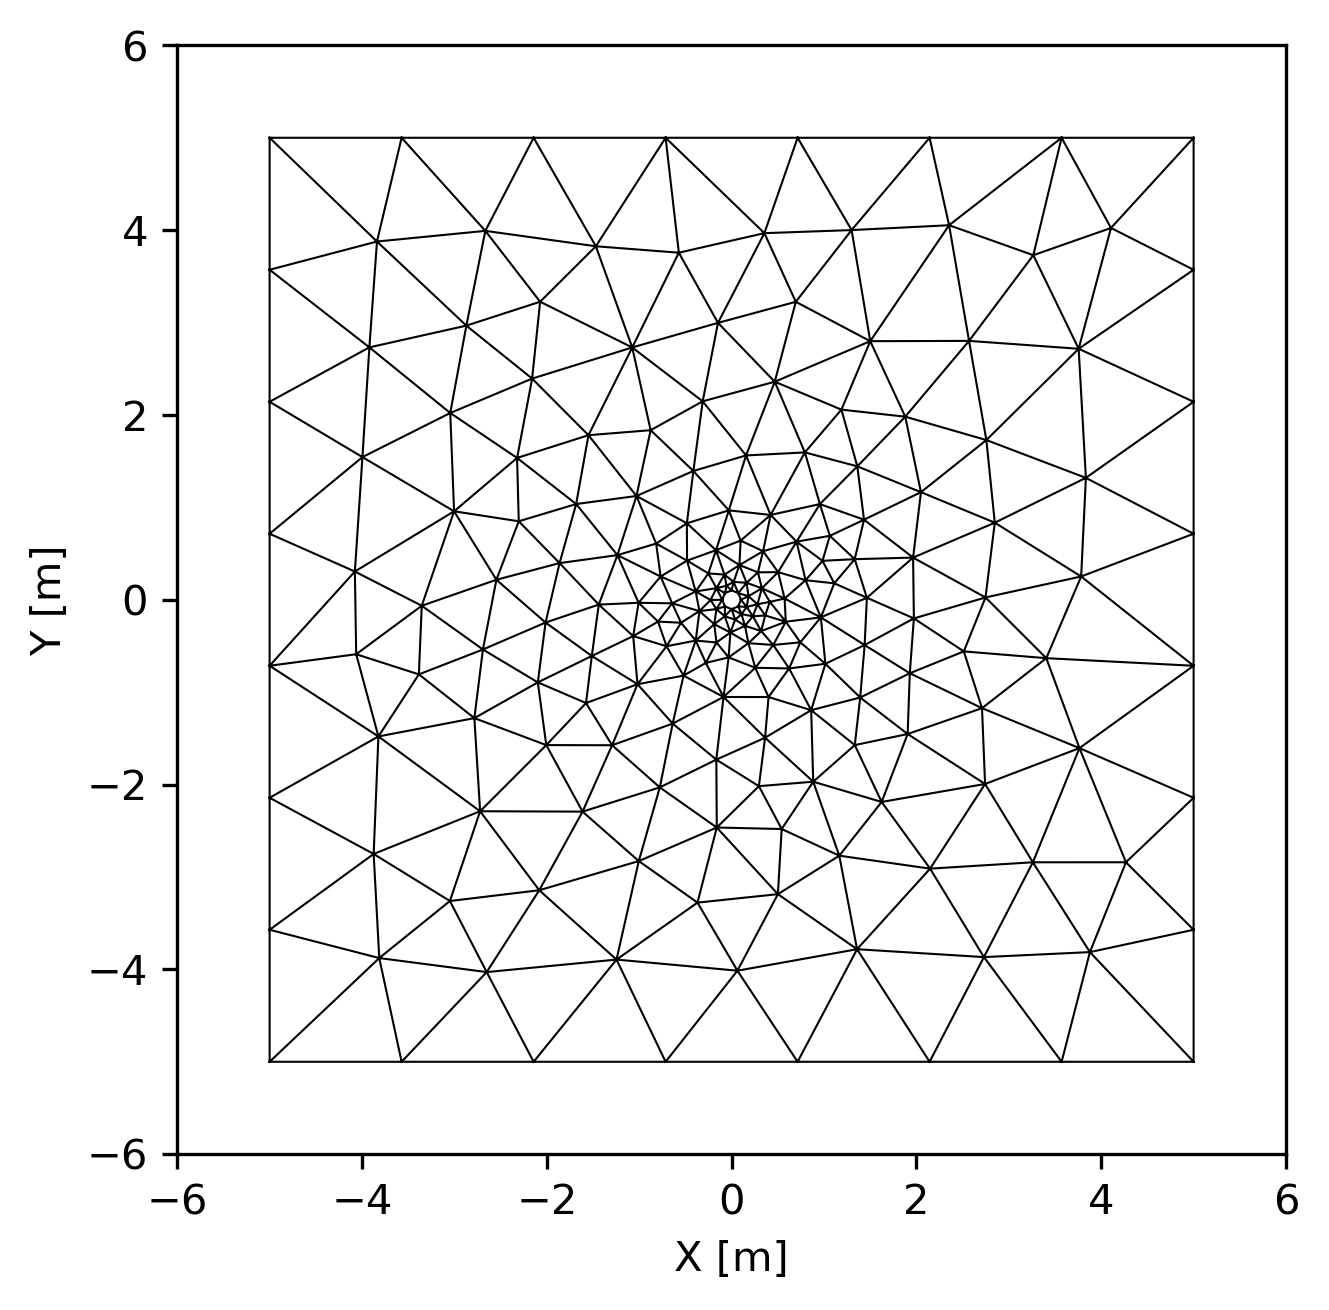

In [3]:
ms,ms_w,xl,yl,dw = 1.5, 0.1, 10, 10, 0.2032
mesh, coord, connectivity, norm, coord2 = generate_mesh(ms,ms_w,xl,yl,dw)
plot(mesh)

### 2. Nodes Coordinates

In [4]:
len(coord2)

612

### 3. Connectivity Array

In [5]:
connectivity.shape

(372, 3)

In [6]:
connectivity
# print(mesh)

array([[ 49,  48,  50],
       [ 94,  18, 181],
       [ 59,  95, 167],
       ...,
       [182, 149, 191],
       [198,  68, 199],
       [149, 182, 204]], dtype=uint64)

### 4. Extract dofs for each boundary

In [7]:
dof_top = np.where(np.isclose(mesh[0][:,1],5))[0]
dof_base = np.where(np.isclose(mesh[0][:,1],-5))[0]
dof_left = np.where((np.isclose(mesh[0][:,0],-5)))[0]
dof_right = np.where((np.isclose(mesh[0][:,0],5)))[0]
dof_well = np.where(np.isclose(mesh[0][:,0]**2 + mesh[0][:,1]**2, 0.1016**2 ))[0]

In [8]:
dof_top

array([ 2,  3, 19, 20, 21, 22, 23, 24])

In [9]:
dof_base

array([ 0,  1,  7,  8,  9, 10, 11, 12])

In [10]:
dof_left

array([ 0,  3, 25, 26, 27, 28, 29, 30])

In [11]:
dof_right

array([ 1,  2, 13, 14, 15, 16, 17, 18])

In [12]:
dof_well

array([ 5,  6, 31, 32, 33, 34, 35, 36])

In [13]:
print(dof_top.shape)
print(dof_base.shape)
print(dof_left.shape)
print(dof_right.shape)
print(dof_well.shape)


(8,)
(8,)
(8,)
(8,)
(8,)


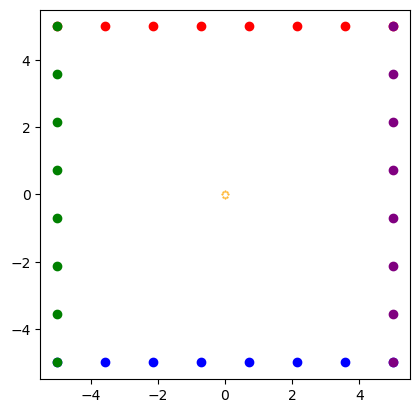

In [14]:
for i in dof_top:
    plt.plot(coord[i,0], coord[i, 1], 'o', c='red')
for i in dof_base:
    plt.plot(coord[i,0], coord[i, 1], 'o', c='blue')
for i in dof_left:
    plt.plot(coord[i,0], coord[i, 1], 'o', c='green')
for i in dof_right:
    plt.plot(coord[i,0], coord[i, 1], 'o', c='purple')
for i in dof_well:
    plt.plot(coord[i,0], coord[i, 1], 'o', markersize=0.5, c='orange')
ax = plt.gca()
ax.set_aspect('equal')
plt.show()

### 5. Read in Material properties

In [15]:
E,nu = 10e9, 0.30
G = E/2/(1+nu)
D = E/((1+nu)*(1-2*nu))*np.array([[1-nu,nu,0],
                                  [nu,1-nu,0],
                                  [0,0,(1-2*nu)/2]])


### 6. Initialize K global and F global

In [16]:
K_global = assemble_matrix(mesh,D)
F_global = scipy.sparse.csr_matrix((len(mesh[0])*2,1),dtype=np.float32) #initialize as zeros # eqn of circle np.isclose(x2 + yy^2, radius_well)

/opt/anaconda3/envs/research/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### 7. Definition of Well Pressure BC

In [17]:
# Find tetha angle for each node in the well 
tetha = np.arctan(coord[dof_well, 1]/coord[dof_well, 0]) #units: radians
# print(tetha)

# Convert tetha angle to degress
tetha_deg = tetha * 180 / np.pi #units: deg
# print(tetha_deg)

# Check x-coord for each dof_well
# coord[dof_well, 0]

# Check y-coord for each dof_well
# coord[dof_well, 1]

# Normal vector decompoosition in nx and ny
radius = 0.01016
nx_ny = np.ones((len(dof_well), 2))
for i in range(0, len(tetha)):
    # print(tetha[i])
    nx_ny[i,0] = radius * np.cos(tetha[i])
    nx_ny[i,1] = radius * np.sin(tetha[i])
    nx_ny[i,0] = radius * np.cos(tetha[i])
    nx_ny[i,1] = radius * np.sin(tetha[i])
# print(nx_ny)

/var/folders/3y/bk1v341s3wx27cb2sv6r6d3c0000gn/T/ipykernel_69156/4085864955.py:2: RuntimeWarning: divide by zero encountered in true_divide
  tetha = np.arctan(coord[dof_well, 1]/coord[dof_well, 0]) #units: radians


### 7. Set Boundary Conditions  

Assuming:  
- Load in top. 
- Load in left  
- fixed y-displacement in base
- fixed x-displacement in right
- Well pressure = mud pressure --> nodal force vector

In [18]:
def set_bc(K, F, dof, val):
    K[dof] = 0.0
    K[dof, dof] = 1.0
    F[dof] = val
# BC due to stress on well 
Pw = -1.0e6 # Wellbore pressure [Pa]
well_load = (Pw * 2 * np.pi * 0.1016) / 64 # len(dof_well) = 64

set_bc(K_global, F_global, dof_base*2+1, 0.0) 
set_bc(K_global, F_global, dof_right*2, 0.0)

# BC  on right and bottom --> ROLLER --> bottom= FIX X & right displ --> FIX Y displ 
# set_bc(K_global,F_global,2*dof_base+1,0.0)
# set_bc(K_global,F_global,2*dof_side,0.0)
#Loads
F_global[2*dof_top+1] = -3e6/len(dof_top) # sigma_yy
F_global[2*dof_left] = -12e6/len(dof_left) #sigma_xx

# F_global[2*end_top+1] *= 0.5
# F_global[2*end_left] *= 0.5
for dwell, xy in zip(dof_well, nx_ny):
    # print(xy)
    F_global[2*dwell]=xy[0]*Pw
    F_global[2*dwell+1]=xy[1]*Pw
    

/opt/anaconda3/envs/research/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### 8. Solver

In [19]:
if Direct:
    u = scipy.sparse.linalg.spsolve(K_global,F_global)#,permc_spec='COLAMD',use_umfpack=True)
if Iterative:
    u = scipy.sparse.linalg.cg(K_global,F_global.toarray())[0]
    
ux = u[0::2]
uy = u[1::2]
#plot(mesh, uy)

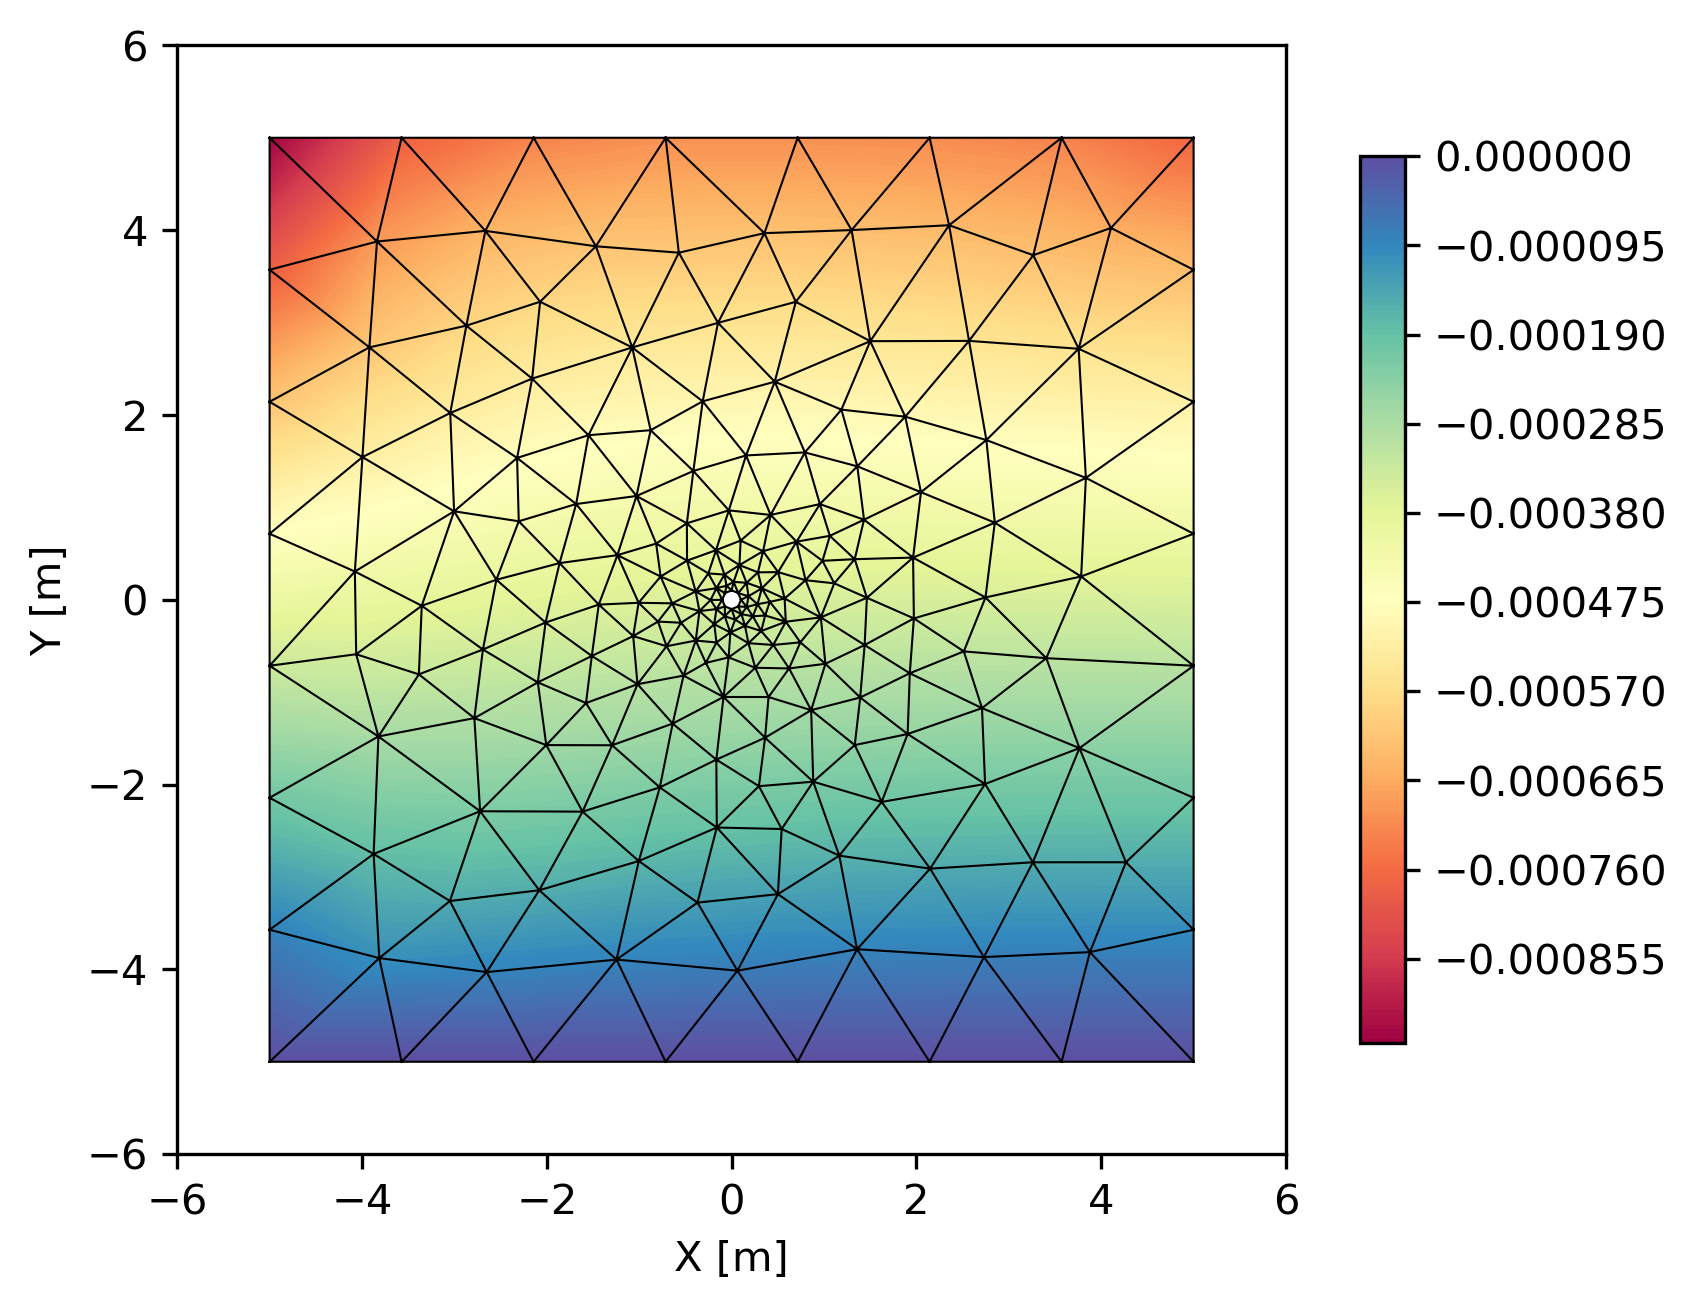

In [20]:
plot(mesh, uy)

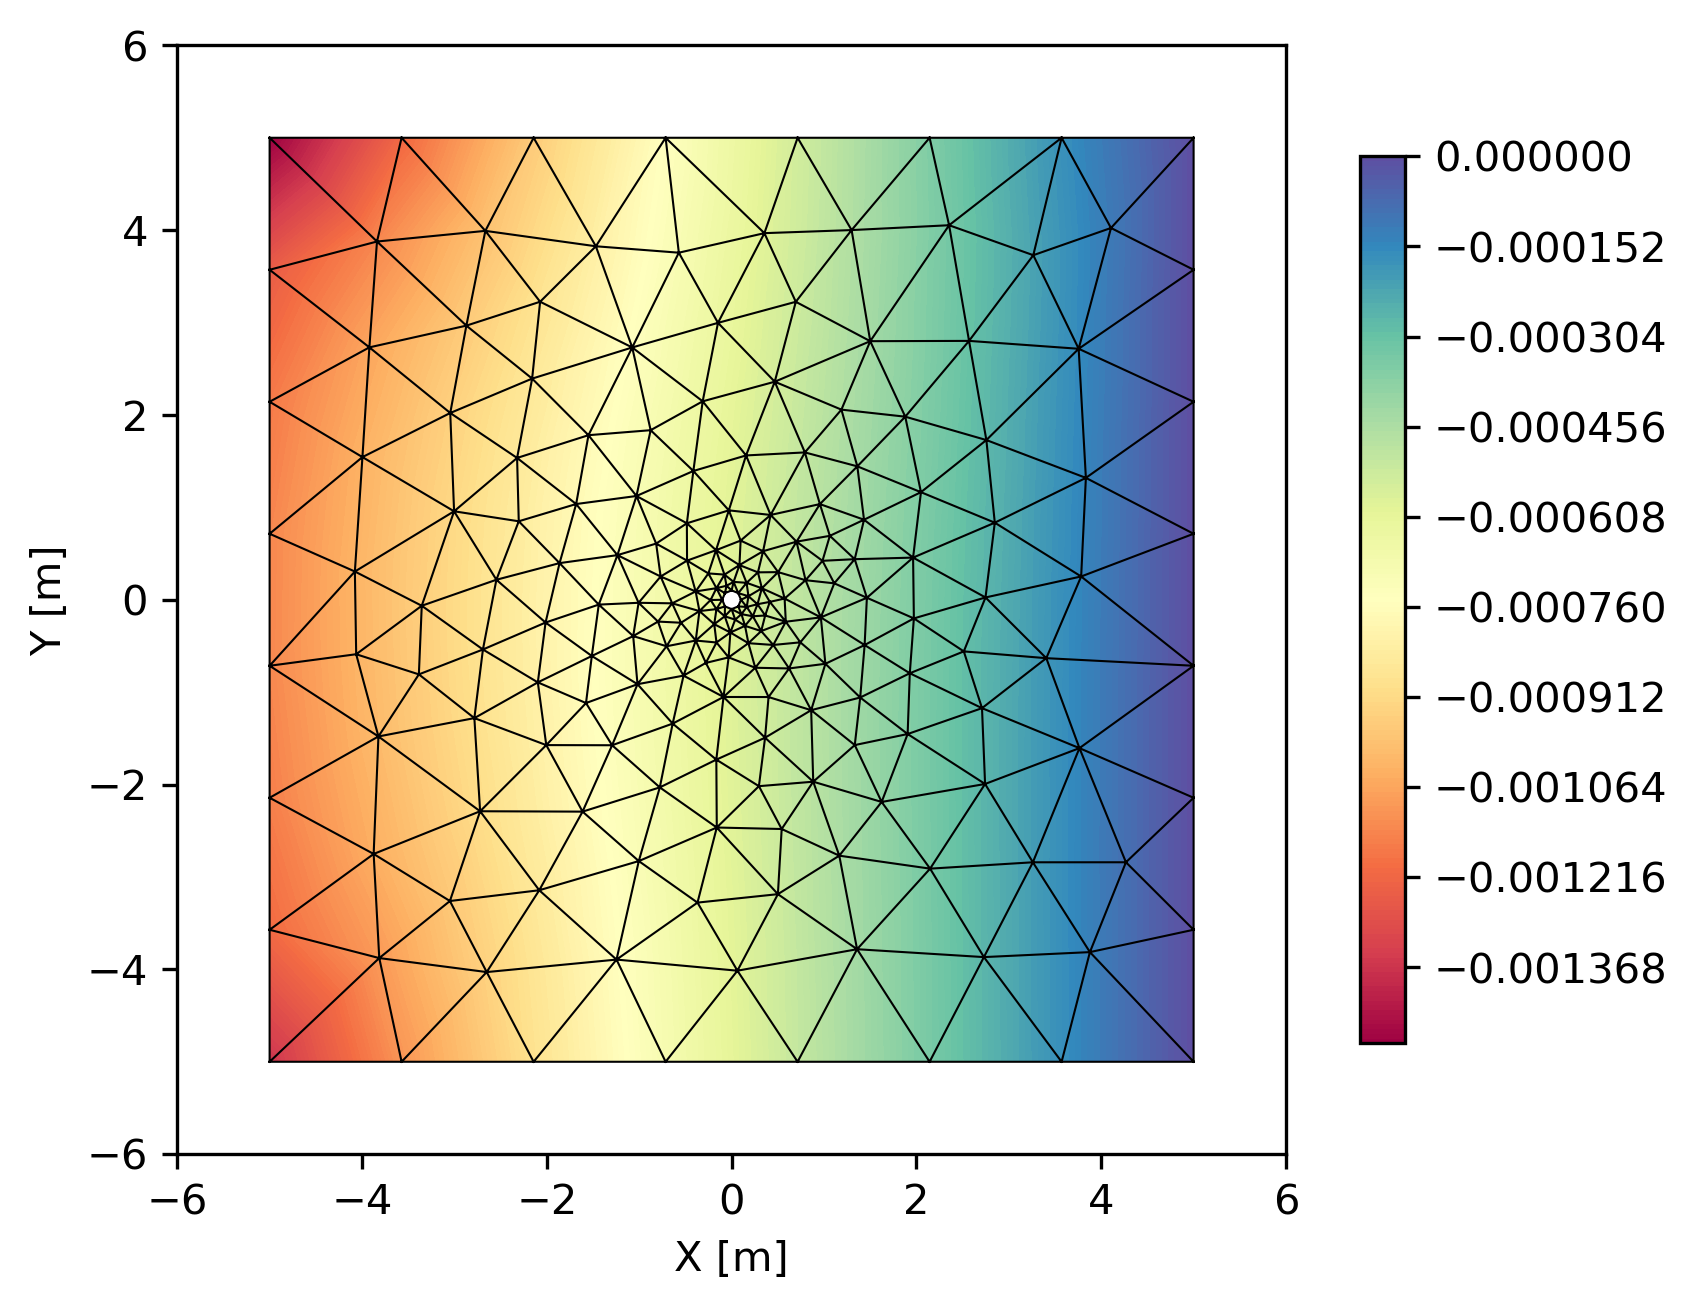

In [21]:
plot(mesh,ux)

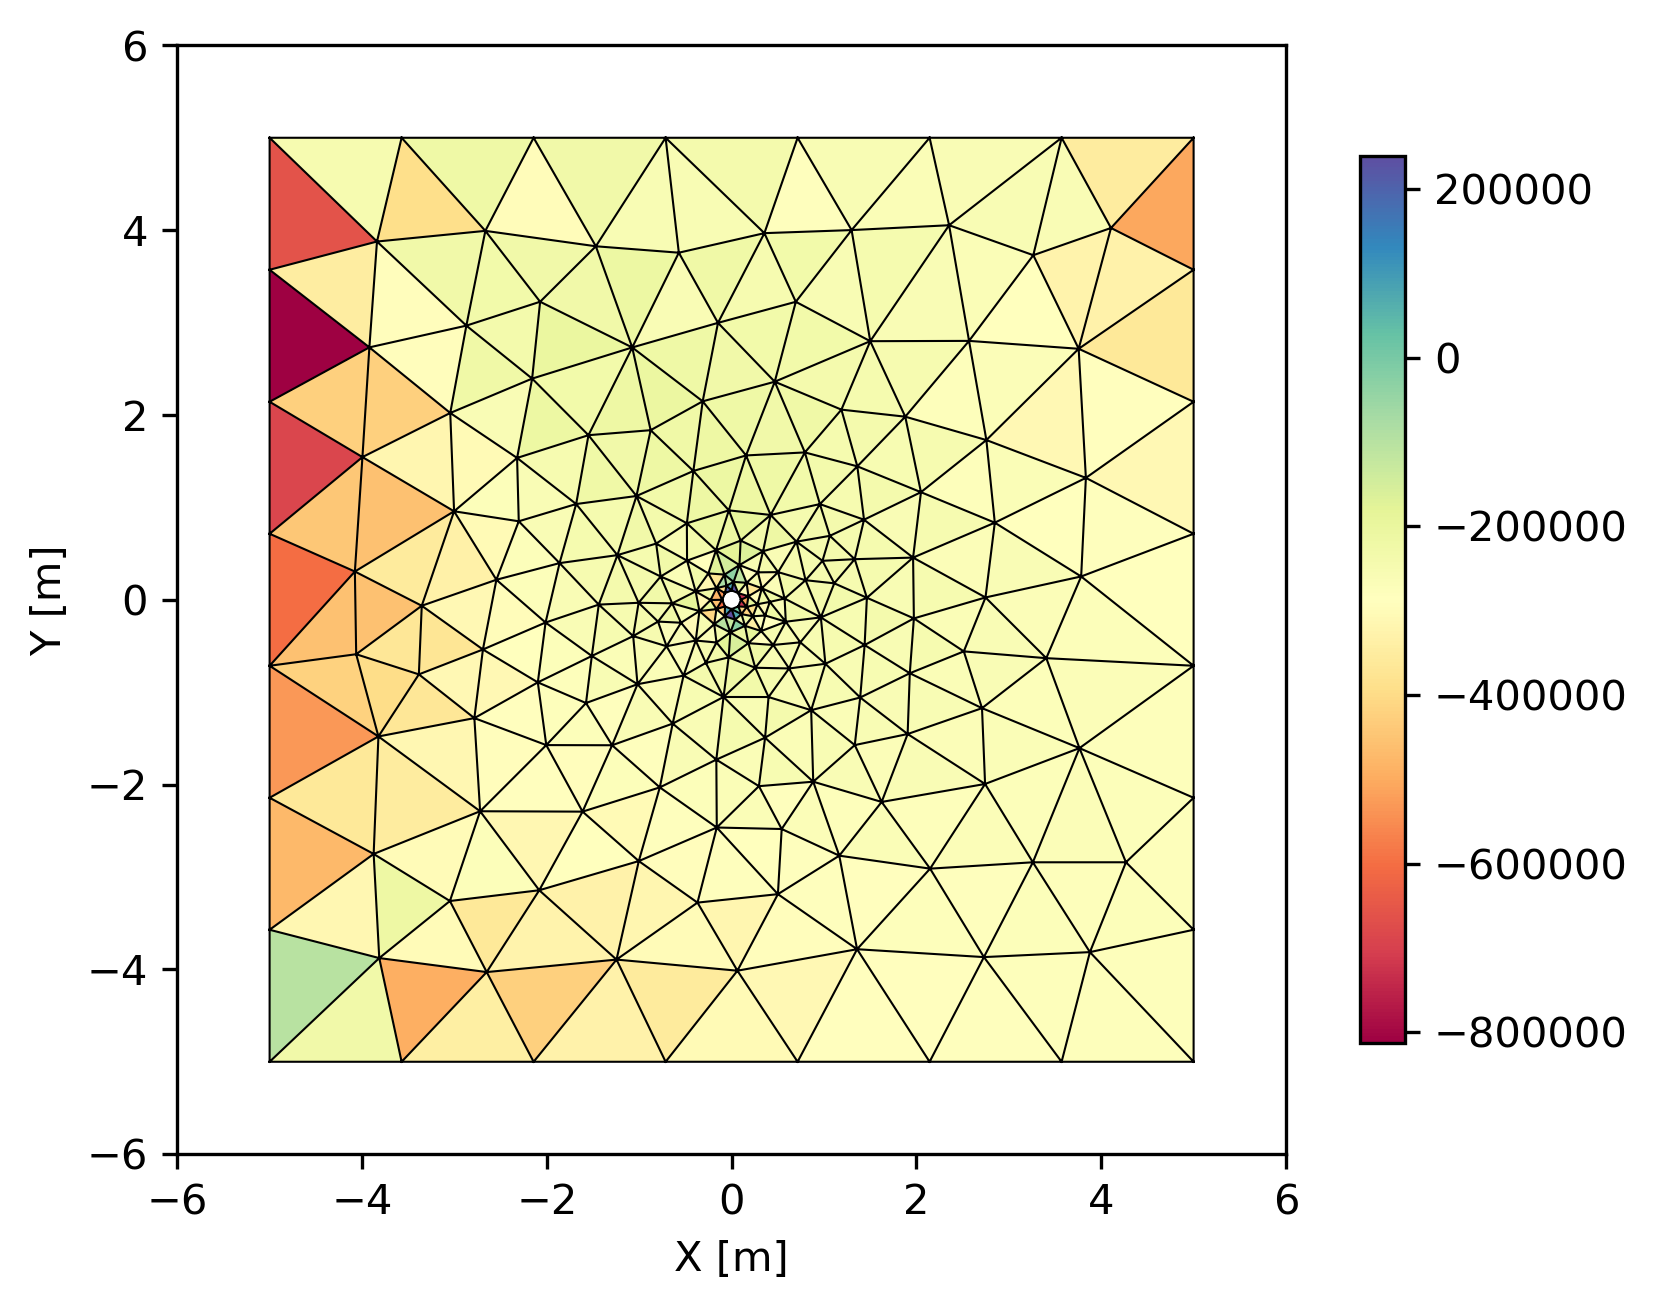

In [23]:
def element_gradient(points,coords):
    assert (len(points) == 3)
    x0, y0, z0 = coords[points[0]]
    x1, y1, z1 = coords[points[1]]
    x2, y2, z2 = coords[points[2]]
    
    Ae = 0.5*abs((x0 - x1)*(y2 - y1) - (y0 - y1)*(x2 - x1))
    Be = np.array([[y1 - y2,     0.0, y2 - y0,     0.0, y0 - y1,     0.0],
               [    0.0, x2 - x1,     0.0, x0 - x2,     0.0, x1 - x0],
               [x2 - x1, y1 - y2, x0 - x2, y2 - y0, x1 - x0, y0 - y1]])/(2*Ae)
    return Be,Ae

def compute_stress_strain(mesh,u,D):
    coords,points = mesh
    strain = np.zeros((len(points),3))
    stress = np.zeros((len(points),3))
    
    for (i,tri) in enumerate(points):
        Be,Ae = element_gradient(tri,coords)
        uu = np.array([u[int(2*tri[0])],u[int(2*tri[0]+1)],
                       u[int(2*tri[1])],u[int(2*tri[1]+1)],
                       u[int(2*tri[2])],u[int(2*tri[2]+1)]])
        strain[i,:] = np.matmul(Be,uu)
        stress[i,:] = np.matmul(D,strain[i,:])
    return strain,stress

strain,stress = compute_stress_strain(mesh,u,D)
plot(mesh, stress[:,1]) #sigma_yy

In [24]:
print(stress[:,1])

[-258595.33800199 -331819.28895546 -250478.10437693 -361659.83426642
 -237063.45701058 -247638.74631644 -232631.35250433 -248156.60165912
 -285357.54680304 -247132.13375226  234065.27309141 -213058.0137507
 -534911.87345899 -242907.6233181  -326305.78643182  -10952.42365181
 -301472.11720476 -259601.95490741 -223724.91605352 -253480.92229909
 -600208.54781837 -239919.36216378 -244104.66151854 -354462.25828227
 -734174.98531209 -239649.13776432 -257718.25794941 -221660.24762187
 -125073.19590674 -302837.95490187 -277671.33043659 -247165.9279635
 -274234.58311967 -286643.6227699  -245734.17060565 -259303.63688381
 -219810.03057781 -262913.80295874 -233942.67962504 -249784.04996512
 -269429.63340534 -239906.25945378 -275531.08192111 -352630.83922514
 -231618.65444976 -254385.01412377 -263502.21485927 -289642.73658661
 -279552.52758662 -308018.16893283 -241012.09241673  -99702.00222599
 -289968.35375114 -261739.97771706 -324246.30865173 -253766.59239827
 -311468.87910621 -531241.77533631 -

In [25]:
strain

array([[ 1.16780580e-04, -6.92587596e-05, -7.34528271e-06],
       [ 1.29117460e-04, -7.99854873e-05, -1.07812608e-05],
       [ 1.14574695e-04, -6.77103857e-05,  2.06631342e-06],
       ...,
       [ 9.97806262e-05, -6.55559265e-05,  1.48581037e-05],
       [ 1.08201100e-04, -6.47045254e-05,  9.59623054e-07],
       [ 1.15056356e-04, -6.81999911e-05,  2.13796776e-05]])

In [26]:
strain.shape

(372, 3)

In [27]:
stress

array([[1172476.50804674, -258595.33800199,  -28251.08733595],
       [1276664.92237238, -331819.28895546,  -41466.38781376],
       [1151714.82517686, -250478.10437693,    7947.35929002],
       ...,
       [ 964993.46852936, -306826.1678497 ,   57146.55262457],
       [1083257.93072801, -246785.34146923,    3690.85789853],
       [1155374.07640379, -254290.13320685,   82229.52928862]])

In [28]:
stress.shape

(372, 3)

---  
### Apr 18 - verify output from meshing fn

In [29]:
mesh

(array([[-5.00000000e+00, -5.00000000e+00,  0.00000000e+00],
        [ 5.00000000e+00, -5.00000000e+00,  0.00000000e+00],
        [ 5.00000000e+00,  5.00000000e+00,  0.00000000e+00],
        [-5.00000000e+00,  5.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.01600000e-01,  0.00000000e+00],
        [ 0.00000000e+00, -1.01600000e-01,  0.00000000e+00],
        [-3.57142857e+00, -5.00000000e+00,  0.00000000e+00],
        [-2.14285714e+00, -5.00000000e+00,  0.00000000e+00],
        [-7.14285714e-01, -5.00000000e+00,  0.00000000e+00],
        [ 7.14285714e-01, -5.00000000e+00,  0.00000000e+00],
        [ 2.14285714e+00, -5.00000000e+00,  0.00000000e+00],
        [ 3.57142857e+00, -5.00000000e+00,  0.00000000e+00],
        [ 5.00000000e+00, -3.57142857e+00,  0.00000000e+00],
        [ 5.00000000e+00, -2.14285714e+00,  0.00000000e+00],
        [ 5.00000000e+00, -7.14285714e-01,  0.00000000e+00],
        [ 5.00000000e+00

In [30]:
coord.shape

(205, 3)

In [31]:
connectivity.shape

(372, 3)

---  
### Normals with GMSH  
This was done originally following the gmsh tutotial for normals

In [32]:
# norm
# normals = []
# for i in range(0, len(coord2), 3):
#         normals.append(coord2[i])
#         normals.append(coord2[i + 1])
#         normals.append(coord2[i + 2])
#         normals.append(norm[i])
#         normals.append(norm[i + 1])
#         normals.append(norm[i + 2]) 

In [33]:
# normals

In [34]:
# gmsh.initialize()
# # Create a list-based vector view on points to display the normals, and a scalar
# # view on points to display the curvatures
# vn = gmsh.view.add("normals")
# gmsh.view.addListData(vn, "VP", len(normals) // 6, normals)
# gmsh.view.option.setNumber(vn, 'ShowScale', 0)
# gmsh.view.option.setNumber(vn, 'ArrowSizeMax', 30)
# gmsh.view.option.setNumber(vn, 'ColormapNumber', 19)
# # vc = gmsh.view.add("curvatures")
# # gmsh.view.addListData(vc, "SP", len(curvatures) // 4, curvatures)
# # gmsh.view.option.setNumber(vc, 'ShowScale', 0)

# # # Launch the GUI to see the results:
# # if '-nopopup' not in sys.argv:
# #     gmsh.fltk.run()
# # Display mesh
# gmsh.fltk.run()
# gmsh.finalize()


In [35]:
# coord.shape

In [36]:
# coord2.shape

In [37]:
# coord2 = coord2.reshape((int(len(coord2)/3),3))
# sorted_ind = np.lexsort((coord2[:,2], coord2[:,1],coord2[:,0]))

In [38]:
# coord2.shape